In [1]:
import os
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import imageio as io
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.util import random_noise

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import resize # Import resize for image resizing

# Load BSD500 dataset
train_dir = '/content/drive/MyDrive/BSD500/BSD500/images/train'
val_dir = '/content/drive/MyDrive/BSD500/BSD500/images/val'
test_dir = '/content/drive/MyDrive/BSD500/BSD500/images/test'

train_noisy_images = []
train_clean_images = []
val_noisy_images = []
val_clean_images = []
test_noisy_images = []
test_clean_images = []

# Define a target size for resizing images
target_size = (256, 256) # Example target size, adjust as needed

for filename in os.listdir(train_dir):
    if filename.endswith(".jpg"):
        img = imread(os.path.join(train_dir, filename))
        # Resize the image to the target size
        img = resize(img, target_size)
        noisy_img = random_noise(img, mode='gaussian', var=0.08**2)
        train_noisy_images.append(noisy_img)
        train_clean_images.append(img)

for filename in os.listdir(val_dir):
    if filename.endswith(".jpg"):
        img = imread(os.path.join(val_dir, filename))
        # Resize the image to the target size
        img = resize(img, target_size)
        noisy_img = random_noise(img, mode='gaussian', var=0.08**2)
        val_noisy_images.append(noisy_img)
        val_clean_images.append(img)

for filename in os.listdir(test_dir):
    if filename.endswith(".jpg"):
        img = imread(os.path.join(test_dir, filename))
        # Resize the image to the target size
        img = resize(img, target_size)
        noisy_img = random_noise(img, mode='gaussian', var=0.08**2)
        test_noisy_images.append(noisy_img)
        test_clean_images.append(img)

# Now you can create NumPy arrays as all images have the same shape
train_noisy_images = np.array(train_noisy_images)
train_clean_images = np.array(train_clean_images)
val_noisy_images = np.array(val_noisy_images)
val_clean_images = np.array(val_clean_images)
test_noisy_images = np.array(test_noisy_images)
test_clean_images = np.array(test_clean_images)

# ... (Rest of your code)

# Define U-Net architecture
def unet_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = keras.layers.Conv2D(512, 2, activation='relu', padding='same')(conv5)
    up6 = keras.layers.UpSampling2D((2, 2))(up6)
    merge6 = keras.layers.Concatenate()([conv4, up6])
    conv6 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = keras.layers.Conv2D(256, 2, activation='relu', padding='same')(conv6)
    up7 = keras.layers.UpSampling2D((2, 2))(up7)
    merge7 = keras.layers.Concatenate()([conv3, up7])
    conv7 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = keras.layers.Conv2D(128, 2, activation='relu', padding='same')(conv7)
    up8 = keras.layers.UpSampling2D((2, 2))(up8)
    merge8 = keras.layers.Concatenate()([conv2, up8])
    conv8 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = keras.layers.Conv2D(64, 2, activation='relu', padding='same')(conv8)
    up9 = keras.layers.UpSampling2D((2, 2))(up9)
    merge9 = keras.layers.Concatenate()([conv1, up9])
    conv9 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(conv9)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

# Compile model
model = unet_model((256, 256, 3))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [3]:
model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=32, validation_data=(test_noisy_images, test_clean_images))

Epoch 1/50
7/7 [==============================] - 106s 6s/step - loss: 0.6896 - accuracy: 0.3819 - val_loss: 0.6774 - val_accuracy: 0.3416
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 0.6575 - accuracy: 0.4551 - val_loss: 0.6718 - val_accuracy: 0.5068
Epoch 3/50
7/7 [==============================] - 12s 2s/step - loss: 0.6617 - accuracy: 0.4835 - val_loss: 0.6233 - val_accuracy: 0.4306
Epoch 4/50
7/7 [==============================] - 14s 2s/step - loss: 0.6056 - accuracy: 0.4854 - val_loss: 0.5801 - val_accuracy: 0.5581
Epoch 5/50
7/7 [==============================] - 12s 2s/step - loss: 0.5766 - accuracy: 0.5541 - val_loss: 0.5617 - val_accuracy: 0.6566
Epoch 6/50
7/7 [==============================] - 14s 2s/step - loss: 0.5679 - accuracy: 0.6975 - val_loss: 0.5581 - val_accuracy: 0.7002
Epoch 7/50
7/7 [==============================] - 12s 2s/step - loss: 0.5632 - accuracy: 0.7075 - val_loss: 0.5542 - val_accuracy: 0.7213
Epoch 8/50
7/7 [=================

In [4]:
denoised_images = model.predict(test_noisy_images)

7/7 [==============================] - 3s 351ms/step


In [8]:
# Calculate PSNR for first 20 noisy images and denoised images
noisy_psnr = []
denoised_psnr = []
for i in range(50):
    noisy_psnr.append(psnr(test_clean_images[i], test_noisy_images[i]))
    denoised_psnr.append(psnr(test_clean_images[i], denoised_images[i]))

print("Noisy PSNR: ")
for i in range(50):
    print("Image {}: {}".format(i+1, noisy_psnr[i]))

print("\nDenoised PSNR: ")
for i in range(50):
    print("Image {}: {}".format(i+1, denoised_psnr[i]))

Noisy PSNR: 
Image 1: 22.023265757436835
Image 2: 21.974304699642886
Image 3: 22.112794477196147
Image 4: 22.101634466833357
Image 5: 22.06826942971288
Image 6: 22.001394968313107
Image 7: 21.955960276125438
Image 8: 22.24800600454721
Image 9: 22.099101307024902
Image 10: 22.029264272165307
Image 11: 22.350871163297175
Image 12: 22.474328975883818
Image 13: 22.03470733332237
Image 14: 21.998012860260054
Image 15: 22.438520635314955
Image 16: 22.26680358994296
Image 17: 22.332431891609424
Image 18: 22.108800939555053
Image 19: 21.99041620483195
Image 20: 21.983893223309895
Image 21: 22.048215795275063
Image 22: 22.41469989870788
Image 23: 22.74387602535533
Image 24: 22.01115887144562
Image 25: 22.053856350942617
Image 26: 22.00051654731862
Image 27: 22.344176175858486
Image 28: 22.23763596227407
Image 29: 22.179174660428586
Image 30: 21.93847937096326
Image 31: 22.05272885664476
Image 32: 22.236784709387763
Image 33: 21.949895049359156
Image 34: 22.053181834328875
Image 35: 21.921602000

<ipython-input-8-eb8f7c40b19c>:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  denoised_psnr.append(psnr(test_clean_images[i], denoised_images[i]))


In [6]:
# Calculate average PSNR for first 20 noisy images and denoised images
noisy_psnr_avg = np.mean(noisy_psnr)
denoised_psnr_avg = np.mean(denoised_psnr)

print("Average Noisy PSNR: {:.2f}".format(noisy_psnr_avg))
print("Average Denoised PSNR: {:.2f}".format(denoised_psnr_avg))

Average Noisy PSNR: 22.13
Average Denoised PSNR: 28.36


7/7 [==============================] - 3s 416ms/step


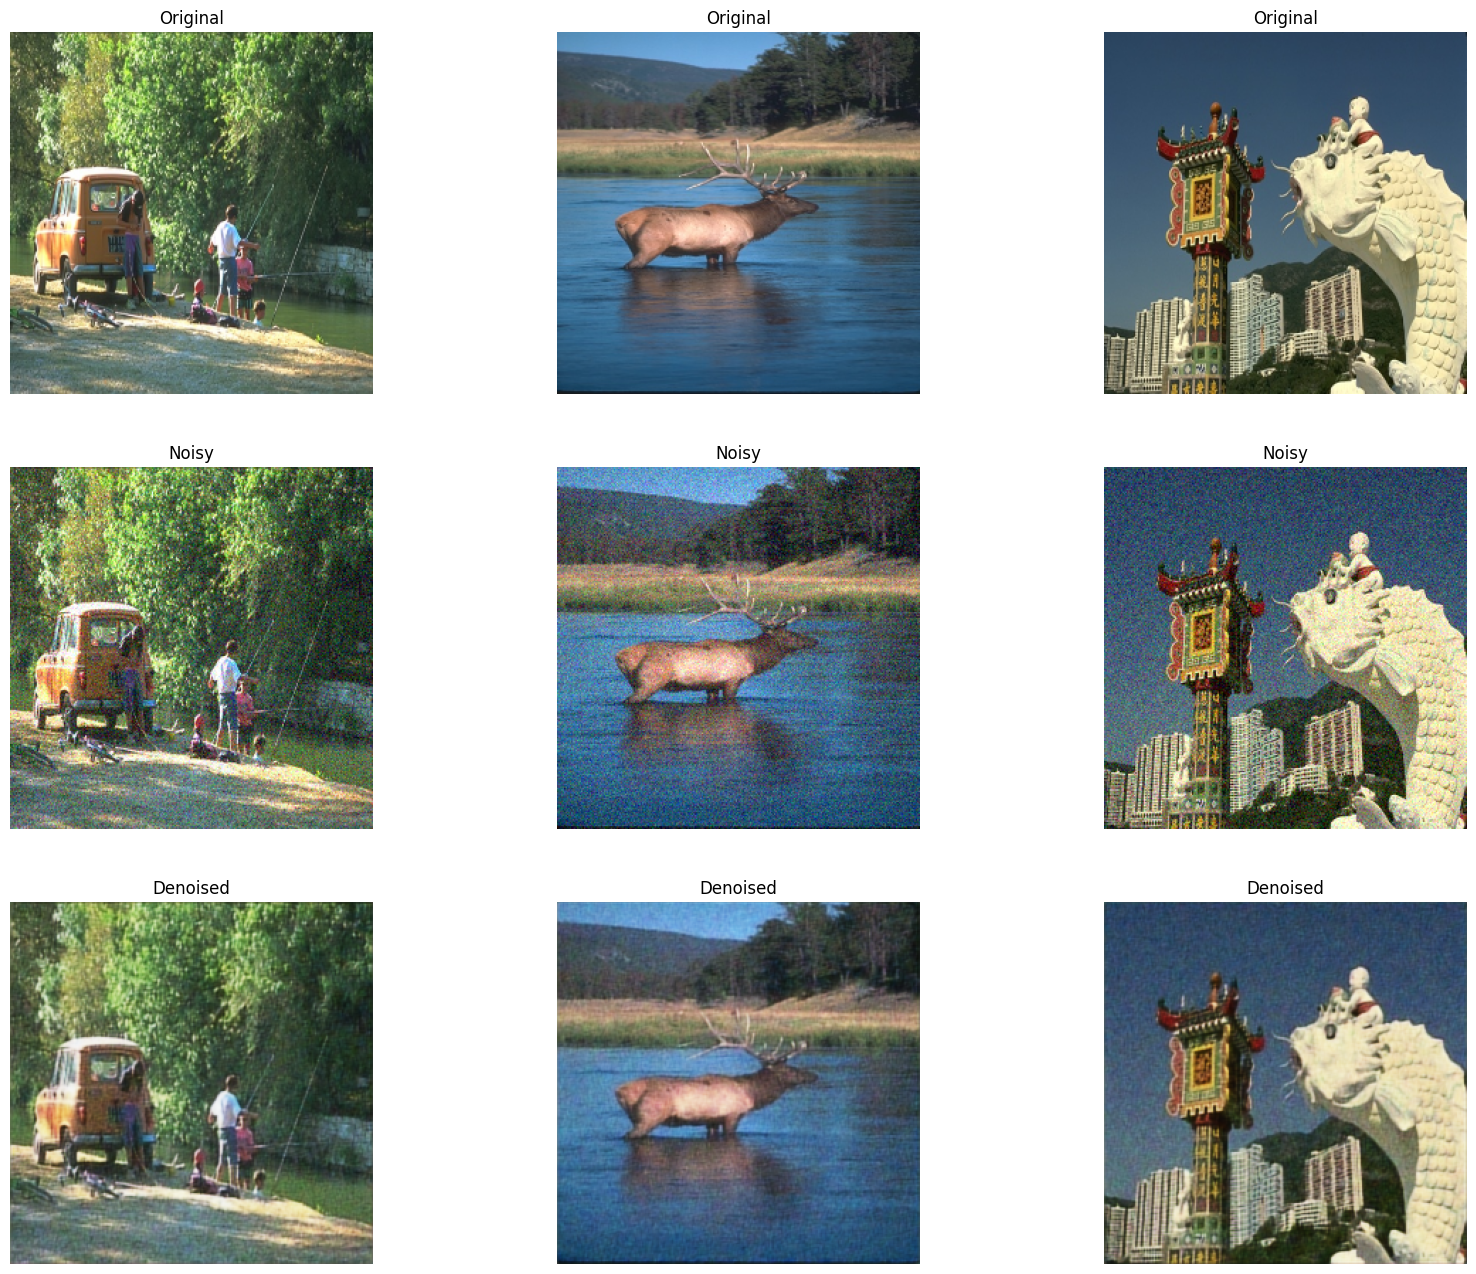

In [7]:
# Predict denoised images
denoised_images = model.predict(test_noisy_images)

# Plot real, noisy, and denoised images
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
for i in range(3):
    # Real images
    axes[0, i].imshow(test_clean_images[i])
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    # Noisy images
    axes[1, i].imshow(test_noisy_images[i])
    axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')
    # Denoised images
    axes[2, i].imshow(denoised_images[i])
    axes[2, i].set_title('Denoised')
    axes[2, i].axis('off')

plt.show()
